In [1]:
import numpy as np
import glob,os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
par.hdr

Populating the interactive namespace from numpy and matplotlib


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                  2.0 / Interlacing                                    
PHILENS =    26.565051177077

In [163]:
lensX=10
lensY=10

from crispy.tools.locate_psflets import PSFLets
from crispy.tools.reduction import get_cutout
polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits' % (par.R))
psflets = polychromeR[0].data
psftool = PSFLets()
lamlist = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x,_y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]    
    ylist += [_y]    

im = Image(filename = par.wavecalDir + 'polychromeR%dstack.fits' % (par.R))
subim, psflet_subarr, [x0, x1, y0, y1] = get_cutout(im,xlist,ylist,psflets)


crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660/polychromeR50stack.fits


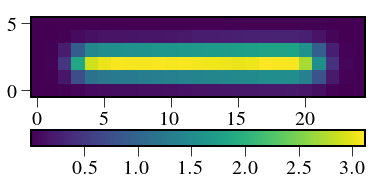

In [164]:
plt.imshow(subim)
plt.colorbar(orientation='horizontal')

In [165]:
print np.sum(subim)

119.967


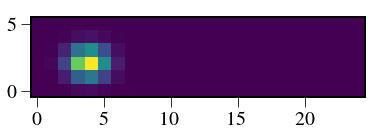

In [166]:
plt.imshow(psflet_subarr[0])
for i in range(psflet_subarr.shape[0]):
    psflet_subarr[i] /= np.sum(psflet_subarr[i])

In [167]:
print 1./np.sum(psflet_subarr[0]**2)

9.63189459363


10.0


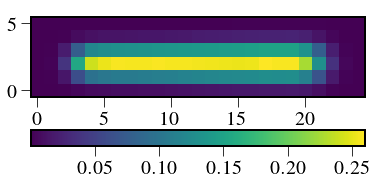

In [189]:
subim = np.sum(psflet_subarr,axis=0)
plt.imshow(subim)
plt.colorbar(orientation='horizontal')
print np.sum(subim)

In [36]:
Nelec = 1000
poisson = np.random.poisson(subim*Nelec)

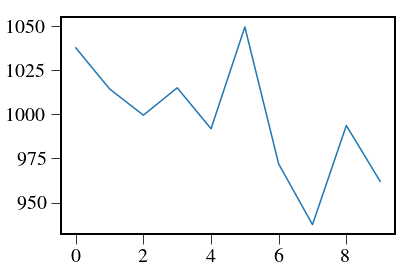

In [37]:
from crispy.IFS import reduceIFSMap
subim_flat = np.reshape(poisson, -1)
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
coef = np.linalg.lstsq(psflets_flat.T, subim_flat)[0]
plt.plot(coef)

Expected SNR: 31.6227766017
Estimated SNR: 30.9676343937
Mean: 999.641133786
Std: 32.280190378


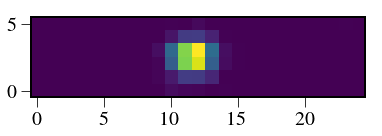

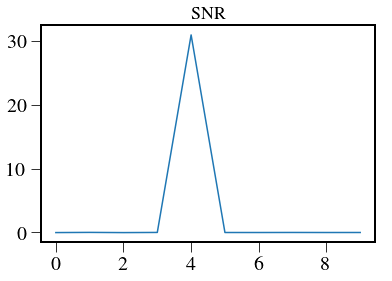

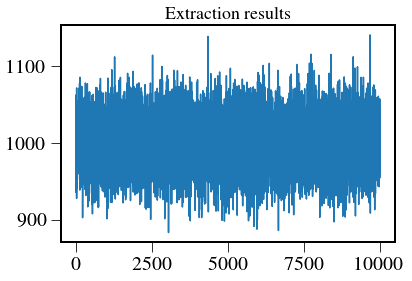

In [98]:
subim = psflet_subarr[4]#np.sum(psflet_subarr,axis=0)
# subim = np.sum(psflet_subarr,axis=0)
sumpsflets = subim+1e-10
Nelec = 1000
Niter = 10000
vals = np.zeros((10,Niter))
for i in range(Niter):
    poisson = np.random.poisson(subim*Nelec)
    subim_flat = np.reshape(poisson/np.sqrt(sumpsflets), -1)
    psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
    sumpsflets_flat = np.reshape(sumpsflets,-1)
    vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
plt.figure()
plt.imshow(poisson)
plt.figure()
plt.plot(estSNR)
plt.title('SNR')
print "Expected SNR:",np.sqrt(Nelec)
print "Estimated SNR:",estSNR[4]

plt.figure()
plt.plot(vals[4])
plt.title('Extraction results')

print 'Mean:',np.mean(vals[4])
print 'Std:',np.std(vals[4])

In [76]:
subim[np.newaxis,:].shape
psflets_flat.T.shape

(150, 10)

In [191]:
# subim = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]
# sumpsflets = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]+1e-10
def calcSNR(Nelec,subim,psflet_subarr,pixnoise=0,npix=0,Niter=10000,plot=True):
    sumpsflets = subim*Nelec+pixnoise+1e-10
    vals = np.zeros((10,Niter))
    for i in range(Niter):
        # subtract mean of background (assumed known)
        img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
        subim_flat = np.reshape(img/np.sqrt(sumpsflets), -1)
        psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
        sumpsflets_flat = np.reshape(sumpsflets,-1)
        vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
    estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.plot(estSNR)
        plt.title('SNR')
        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR:",estSNR[4]
        print "Change:",100*(SNR-estSNR[4])/SNR,"%"

        plt.figure()
        plt.plot(vals[4])
        plt.title('Extraction results')

        print 'Mean:',np.mean(vals[4])
        print 'Std:',np.std(vals[4])
    return estSNR

In [156]:
Nelec = 1000

Expected SNR: 31.6227766017
Estimated SNR: 31.155929856
Change: 1.47629903444 %
Mean: 1000.2008155
Std: 32.1030641717


array([ -8.95176464e-03,   8.23248409e-03,  -4.77073148e-03,
        -4.60724127e-03,   3.11559299e+01,   3.06724016e-04,
        -4.14614733e-03,   4.58686622e-03,  -4.63922040e-03,
         4.59181282e-03])

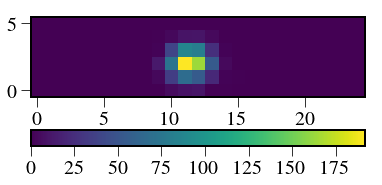

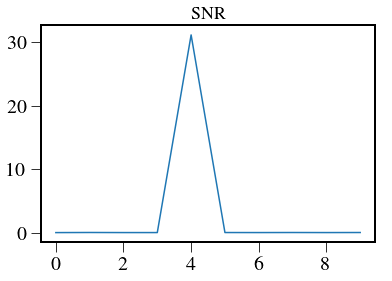

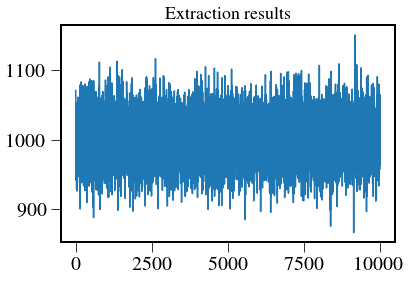

In [192]:
subim = psflet_subarr[4]
calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=0,
        plot=True)


Expected SNR: 31.6227766017
Estimated SNR: 19.0967899798
Change: 39.610647666 %
Mean: 998.657716684
Std: 52.2945331515


array([  3.95996793e-03,  -2.95444601e-03,  -3.08498505e-03,
         2.47993461e+01,   1.90967900e+01,   2.39077109e+01,
        -1.65331646e-02,   6.67806970e-03,  -5.56067854e-03,
         5.29848962e-03])

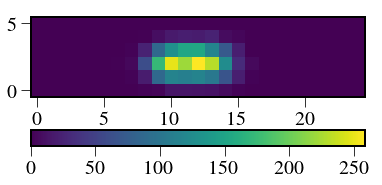

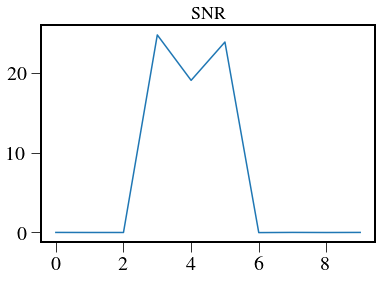

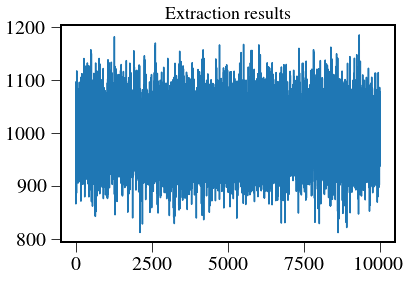

In [193]:
subim = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]
calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=0,
        plot=True)


Expected SNR: 31.6227766017
Estimated SNR: 17.0244871709
Change: 46.1638445436 %
Mean: 999.332617302
Std: 58.6997192497


array([ 25.68243184,  20.14541292,  18.89593135,  18.09086051,
        17.02448717,  16.03296915,  15.44394676,  14.91028529,
        15.84010594,  22.99443699])

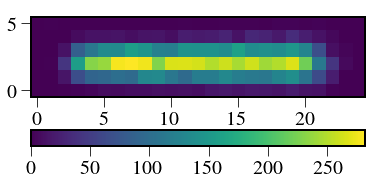

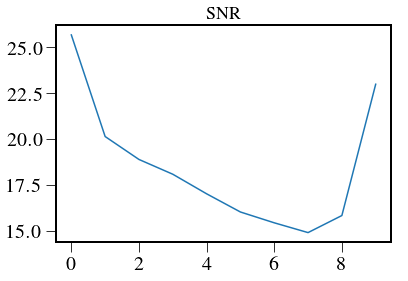

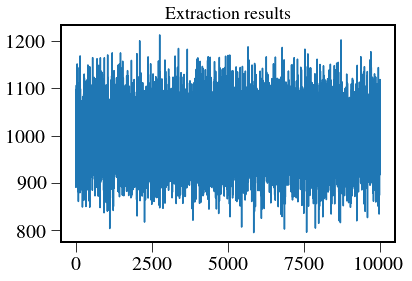

In [194]:
subim = np.sum(psflet_subarr,axis=0)
calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=0,
        plot=True)



Expected SNR: 9.53462589246
Estimated SNR: 6.88169078276
Change: 27.8242181667 %
Mean: 1000.24890453
Std: 145.349295124


array([ -1.16564273e-02,   9.98796925e-03,  -1.34675929e-02,
        -1.03571127e-02,   6.88169078e+00,   1.23015588e-02,
         3.05834008e-03,  -8.97785608e-03,   1.35429766e-02,
        -1.03598799e-02])

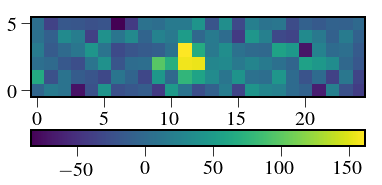

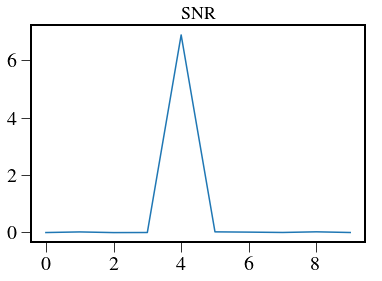

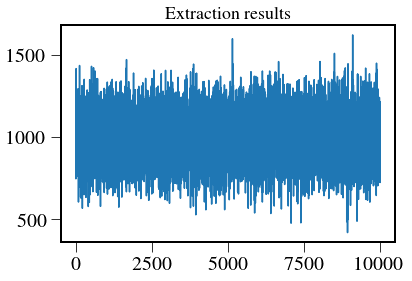

In [172]:
subim = psflet_subarr[4]
calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=1000,
        npix=10,
        plot=True)


This is the main function that suggests that an npix of ~6 is appropriate for the regime we are in (<1000 electrons)

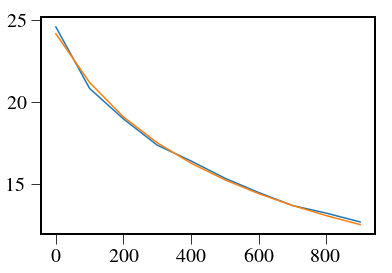

In [208]:
noiselist = np.arange(0,1000,100)  # mean number of electrons from background
estvals = []
compvals = []
npix = 6
Nelec=2000
for val in noiselist:
#     subim = psflet_subarr[4]
    subim = np.sum(psflet_subarr,axis=0)
    estSNR = calcSNR(Nelec=Nelec,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=val,
        npix=npix,
        plot=False)
    estvals.append(estSNR[4])
    compvals.append(Nelec/(np.sqrt(Nelec+npix*val)))
plt.plot(noiselist,estvals)
plt.plot(noiselist,np.array(compvals)*0.54)

### Here we try to calculate the overlap fraction of two neighboring PSFs

In [188]:
np.sum(psflet_subarr[4]*psflet_subarr[5]+psflet_subarr[4]*psflet_subarr[3])

0.081430537510390921

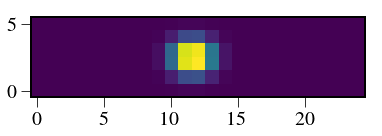

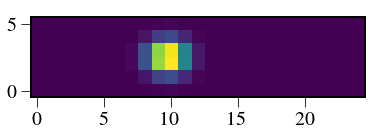

In [191]:
plt.figure()
plt.imshow(psflet_subarr[4])
plt.figure()

plt.imshow(psflet_subarr[3])


0.402294711401
0.810877565754


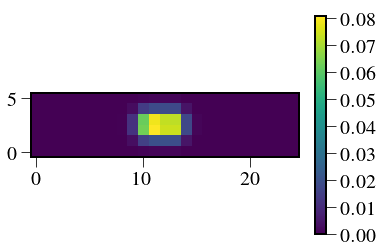

In [204]:
print np.sum(np.minimum(psflet_subarr[4],psflet_subarr[3])+np.minimum(psflet_subarr[4],psflet_subarr[6]))
val=0
img=np.zeros_like(subim)
for i in range(10):
    if i!=4:
        img += np.minimum(psflet_subarr[4],psflet_subarr[i])
        val+=np.sum(np.minimum(psflet_subarr[4],psflet_subarr[i]))
print val
plt.imshow(img)
plt.colorbar()


In [2]:
from crispy.unitTests import testOptExt
im = Image(filename = par.wavecalDir + 'polychromeR%dstack.fits' % (par.R))
spec,var = testOptExt(par,im,54,54,smoothandmask=False)

crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660/polychromeR50stack.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - WARNING - No PSFLet widths found - assuming critical samping at central wavelength


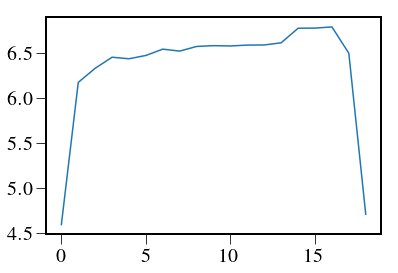

In [5]:
plt.plot(spec)

In [116]:
from crispy.tools.locate_psflets import PSFLets
PSFlet_tool = PSFLets(load=True, infiledir=par.wavecalDir)
i=54
j=54
xindx = PSFlet_tool.xindx
yindx = PSFlet_tool.yindx
Nmax = PSFlet_tool.nlam_max


_x = xindx[i, j, :PSFlet_tool.nlam[i, j]]
_y = yindx[i, j, :PSFlet_tool.nlam[i, j]]
_lam = PSFlet_tool.lam_indx[i, j, :PSFlet_tool.nlam[i, j]]
X = _x-y0
X = X[1:-1]
Y = _y-x0
Y = Y[1:-1]
lam = _lam[1:-1]
print X,Y,_lam

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.] [ 2.48430467  2.4846161   2.48488505  2.48511378  2.48530457  2.48545978
  2.48558134  2.48567283  2.4857371   2.48577668  2.48579567  2.48579714
  2.48578521  2.48576374  2.48573718  2.48571006  2.48568725  2.48567393
  2.48567578  2.48569841  2.485748    2.48583112  2.48595499  2.48612681
  2.48635425  2.48664551] [ 576.74744611  582.56776822  588.44268775  594.37264881  600.35835049
  606.40062819  612.50047722  618.66004432  624.87883289  631.15786097
  637.49968826  643.90332588  650.37139018  656.90367092  663.50229484
  670.16694683  676.90053916  683.70230327  690.57396904  697.51721008
  704.53206937  711.61970547  718.78123942  726.01815774  733.33105824
  740.72074028  748.18813204  755.7341012 ]


In [117]:
subim = np.sum(psflet_subarr,axis=0)
subim*=1000
spec = np.zeros(subim.shape[1])
subim_res = subim.copy()
sig = 2./2.35*lam/par.FWHMlam
y = np.mean(Y)                  
for i in range(subim.shape[1]):
    weights = np.exp(-(np.arange(subim.shape[0])-y)**2/2./sig[i]**2)/sig[i]/np.sqrt(2.*np.pi)
    spec[i] = np.sum(subim[:,i]*weights)/np.sum(weights**2)
    subim_res[:,i] -= spec[i]*weights
    print spec[i]

0.0446018525614
3.27742529873
57.1886856588
267.776676199
464.059651946
503.382148237
517.63097062
520.938413141
524.682808036
534.528985074
535.782353331
542.845373307
547.14135606
550.165539601
554.385271925
557.797197134
563.948038094
580.779276101
582.289961553
586.381659471
538.023559796
337.269050645
108.522932829
14.2039514417
0.670589282647


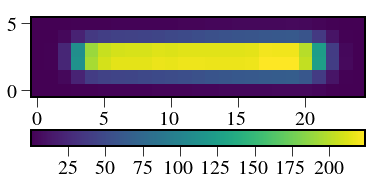

In [120]:
plt.imshow(subim)
plt.colorbar(orientation='horizontal')

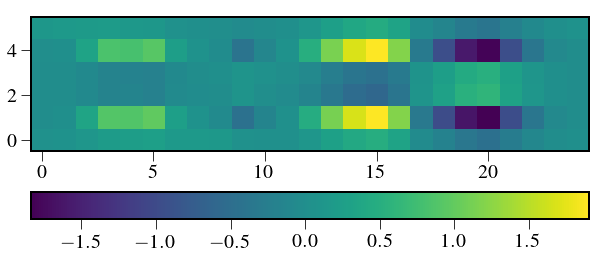

In [119]:
plt.figure(figsize=(10,5))
plt.imshow(subim_res)
plt.colorbar(orientation='horizontal')

In [200]:
from crispy.tools.locate_psflets import PSFLets

def calcSNROptExt(Nelec,subim,pixnoise=0,npix=0,Niter=10000,plot=True):
    PSFlet_tool = PSFLets(load=True, infiledir=par.wavecalDir)
    xindx = PSFlet_tool.xindx
    yindx = PSFlet_tool.yindx
    Nmax = PSFlet_tool.nlam_max

    i=lensX+54
    j=lensY+54
    _x = xindx[i, j, :PSFlet_tool.nlam[i, j]]
    _y = yindx[i, j, :PSFlet_tool.nlam[i, j]]
    _lam = PSFlet_tool.lam_indx[i, j, :PSFlet_tool.nlam[i, j]]
    X = _x-y0
    X = X[1:-1]
    Y = _y-x0
    Y = Y[1:-1]
    lam = _lam[1:-1]

    vals = np.zeros((subim.shape[1],Niter))
    for j in range(Niter):
        # subtract mean of background (assumed known)
        img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
        spec = np.zeros(subim.shape[1])
        sig = 2./2.35*lam/par.FWHMlam
        y = np.mean(Y)                  
        for i in range(img.shape[1]):
            weights = np.exp(-(np.arange(img.shape[0])-y)**2/2./sig[i]**2)/sig[i]/np.sqrt(2.*np.pi)
            vals[i,j] = np.sum(img[:,i]*weights)/np.sum(weights**2)    
    estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
    estSNR_central = np.mean(0.5*(vals[13,:]+vals[14,:]))/np.std(0.5*(vals[13,:]+vals[14,:]))
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.plot(estSNR)
        plt.title('SNR')
        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR:",estSNR_central
        print "Change:",100*(SNR-estSNR_central)/SNR,"%"

        plt.figure()
        plt.plot(vals[4])
        plt.title('Extraction results')

        print 'Mean:',np.mean(0.5*(vals[13,:]+vals[14,:]))
        print 'Std:',np.std(0.5*(vals[13,:]+vals[14,:]))
    return estSNR_central

Expected SNR: 31.6227766017
Estimated SNR: 31.2107892037
Change: 1.30281854503 %
Mean: 549.900953784
Std: 17.6189378037


array([  0.27040382,   2.14276031,   8.13595503,  16.05282627,
        19.98479726,  20.46354341,  20.64617222,  20.76131422,
        21.20873272,  21.03647236,  21.63223922,  21.15233367,
        21.38052993,  21.92690443,  21.83935768,  22.18571597,
        21.91702882,  22.32115096,  22.01193149,  22.58144857,
        20.97975538,  16.01598351,   8.53553894,   2.89301963,   0.58626053])

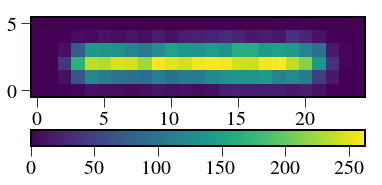

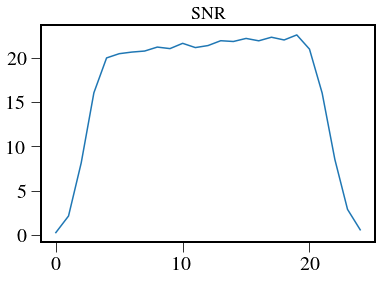

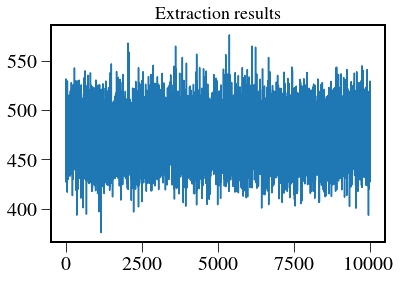

In [198]:
subim = np.sum(psflet_subarr,axis=0)
calcSNROptExt(Nelec=1000,
        subim=subim,
        pixnoise=0,
        npix=6,
        plot=True)

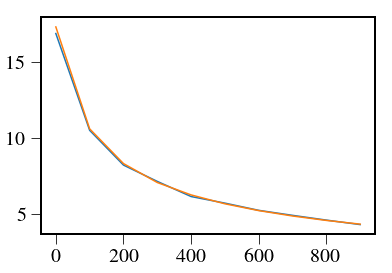

In [207]:
noiselist = np.arange(0,1000,100)  # mean number of electrons from background
estvals = []
compvals = []
npix = 5
Nelec=300
for val in noiselist:
#     subim = psflet_subarr[4]
    subim = np.sum(psflet_subarr,axis=0)
    estSNR = calcSNROptExt(Nelec=Nelec,
        subim=subim,
        pixnoise=val,
        npix=npix,
        plot=False)
    estvals.append(estSNR)
    compvals.append(Nelec/(np.sqrt(Nelec+npix*val)))
plt.figure(figsize=(10,8))
plt.title('Optimal extraction')
plt.plot(noiselist,estvals,label="Simulated")
plt.xlabel('Number of additive noise electrons per pixel')
plt.ylabel('SNR')
plt.plot(noiselist,np.array(compvals),label='Expected with npix=%d' % npix)
plt.legend()

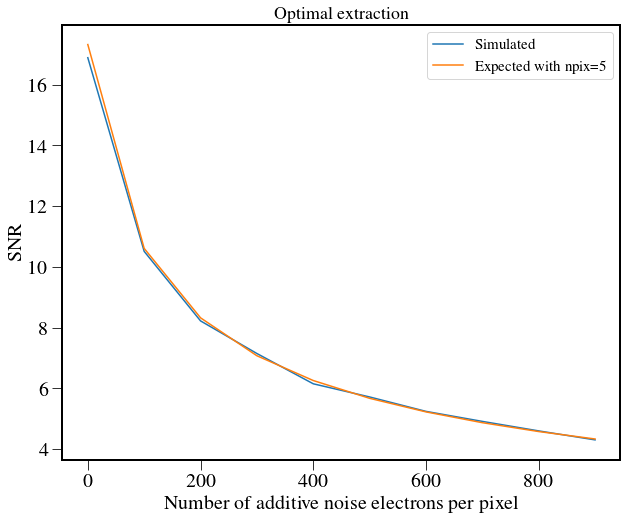

In [208]:
plt.figure(figsize=(10,8))
plt.title('Optimal extraction')
plt.plot(noiselist,estvals,label="Simulated")
plt.xlabel('Number of additive noise electrons per pixel')
plt.ylabel('SNR')
plt.plot(noiselist,np.array(compvals),label='Expected with npix=%d' % npix)
plt.legend()

## Test with Richardson-Lucy deconvolution

In [177]:
# subim = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]
# sumpsflets = psflet_subarr[3]+psflet_subarr[4]+psflet_subarr[5]+1e-10
from crispy.tools.reduction import RL
def calcSNR_RL(Nelec,subim,psflet_subarr,pixnoise=0,npix=0,Niter=10000,plot=True):
    sumpsflets = subim*Nelec+pixnoise+1e-10
    vals = np.zeros((10,Niter))
    for i in range(Niter):
        # subtract mean of background (assumed known)
        img = np.random.poisson(subim*Nelec)+np.random.poisson(pixnoise,subim.shape)-pixnoise
#         subim_flat = np.reshape(img/np.sqrt(sumpsflets), -1)
#         psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
#         sumpsflets_flat = np.reshape(sumpsflets,-1)
#         vals[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets_flat[:,np.newaxis])), subim_flat)[0]
        vals[:,i] = RL(img,psflets=psflet_subarr)[0]
    estSNR = np.mean(vals,axis=1)/np.std(vals,axis=1)
    if plot:
        plt.figure()
        plt.imshow(img)
        plt.colorbar(orientation='horizontal')
        plt.figure()
        plt.plot(estSNR)
        plt.title('SNR')
        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",SNR
        print "Estimated SNR:",estSNR[4]
        print "Change:",100*(SNR-estSNR[4])/SNR,"%"

        plt.figure()
        plt.plot(vals[4])
        plt.title('Extraction results')

        print 'Mean:',np.mean(vals[4])
        print 'Std:',np.std(vals[4])
    return estSNR

Expected SNR: 31.6227766017
Estimated SNR: 16.3542561444
Change: 48.2833011459 %
Mean: 1000.03944128
Std: 61.1485739525


array([ 25.29353844,  19.03189105,  17.99034366,  17.26681037,
        16.35425614,  15.38258849,  14.89139398,  14.27061078,
        14.59881942,  21.86956021])

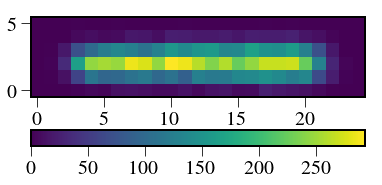

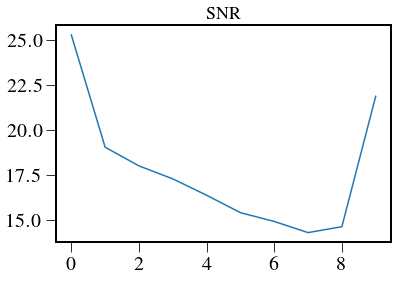

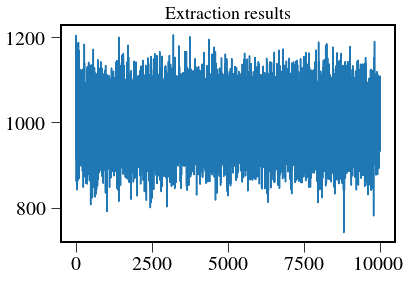

In [178]:
subim = np.sum(psflet_subarr,axis=0)
calcSNR_RL(Nelec=1000,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=10,
        plot=True)

### Attempt truncating the PSFLet templates to only the brightest pixels

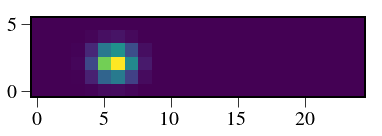

In [150]:
psflet_subarr.shape
psflet_subarr_trunc = psflet_subarr.copy()
for i in range(psflet_subarr.shape[0]):
    psflet_subarr_trunc[i][psflet_subarr_trunc[i]<0.0*np.amax(psflet_subarr_trunc[i])] = 0.0
plt.imshow(psflet_subarr_trunc[1])

Expected SNR: 31.6227766017
Estimated SNR: 16.2497674921
Change: 48.6137232767 %
Mean: 1000.11448588
Std: 61.54638744
Expected SNR: 31.6227766017
Estimated SNR: 17.0778868326
Change: 45.9949799862 %
Mean: 999.480937119
Std: 58.5248600669


array([ 25.93189601,  19.93480401,  18.74626713,  17.77729454,
        17.07788683,  16.15315762,  15.41766018,  14.98195899,
        15.69786372,  22.90833254])

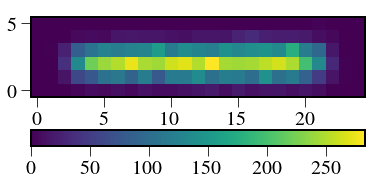

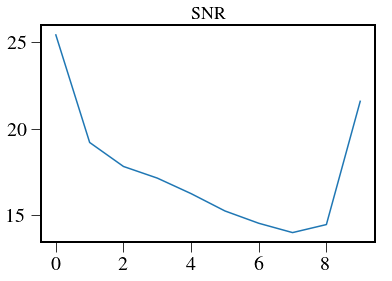

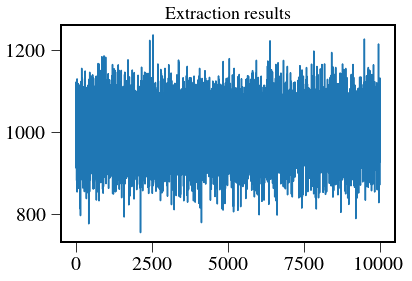

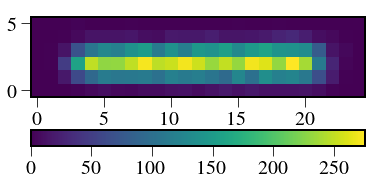

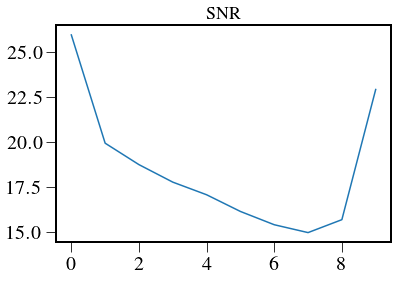

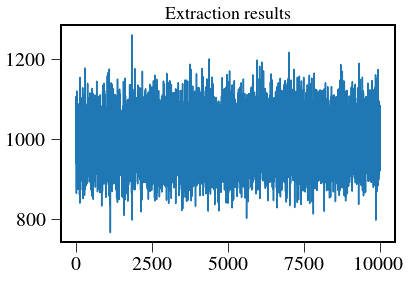

In [196]:
subim = np.sum(psflet_subarr,axis=0)
calcSNR_RL(Nelec=1000,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=10,
        plot=True)
subim = np.sum(psflet_subarr,axis=0)
calcSNR(Nelec=1000,
        subim=subim,
        psflet_subarr=psflet_subarr,
        pixnoise=0,
        npix=10,
        plot=True)